<a href="https://colab.research.google.com/github/Oanh0305/CSCA-5642_week3_project/blob/main/Cancer_Detection_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rm -R /root/.kaggle

rm: cannot remove '/root/.kaggle': No such file or directory


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/




Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                                  title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
shreyanshverma27/online-sales-dataset-popular-marketplace-data       Online Sales Dataset - Popular Marketplace Data    7KB  2024-05-25 23:55:26           9555        168  1.0              
teocalvo/teomewhy-loyalty-system                                     TeoMeWhy Loyalty System                           23MB  2024-06-20 20:48:14            282        407  1.0              
sahilprajapati143/retail-analysis-large-dataset                      Retail Analysis on Large Dataset                  26MB  2024-06-14 18:32:07            920         23  1.0              
rabieelkharoua/students-performance-dataset       

In [ ]:
! kaggle competitions download -c 'histopathologic-cancer-detection'

... resuming from 595591168 bytes (6177637257 bytes left) ...
100% 6.29G/6.31G [00:47<00:00, 160MB/s]
100% 6.31G/6.31G [00:47<00:00, 131MB/s]


In [ ]:
! ls

 gdrive   histopathologic-cancer-detection.zip	'kaggle (1).json'   kaggle.json   sample_data


In [ ]:
! unzip histopathologic-cancer-detection.zip

In [ ]:
! ls

 gdrive				        kaggle.json	        test
 histopathologic-cancer-detection.zip   sample_data	        train
'kaggle (1).json'		        sample_submission.csv   train_labels.csv


# Histopathologic Cancer Setection CNN

## 1. Description of the problem and data

This is a binary image classification problen where you will identify metastatic cancer in small image pathches taken from larger digital pathology scans.
The input data consists of 57,458 unique images, with two columns: 'Id' for the id of each image and 'label' where 0 represents 'not cancer' and 1 represents 'cancer'.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import sklearn
import os
import gc
import cv2

from PIL import Image
from PIL import ImageDraw
train_on_gpu = True

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers,optimizers,models
from keras.metrics import AUC

## 2. Inspect, Visualize and Clean the Data

In [ ]:
# Read data
labels = pd.read_csv('train_labels.csv')
samples = pd.read_csv('sample_submission.csv')
labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [ ]:
train = "train"
test = "test"

print("Number of training images: {}".format(len(os.listdir(train))))
print("Number of test images: {}".format(len(os.listdir(test))))

Number of training images: 220025
Number of test images: 57458


In [ ]:
img_train = os.listdir(train)
img_test = os.listdir(test)

In [ ]:
# Check missing values

missing_values = labels.isnull().sum()
missing_values

id       0
label    0
dtype: int64

In [ ]:
# Check duplicated values

labels[labels.duplicated(keep=False)]

,id,label


In [ ]:
labels['label'].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

['c18f2d887b7ae4f6742ee445113fa1aef383ed77'
 'a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da'
 '7f6ccae485af121e0b6ee733022e226ee6b0c65f' ...
 '309210db7f424edbc22b2d13bf2fa27518b18f5c'
 'd4b854fe38b07fe2831ad73892b3cec877689576'
 'a81f84895ddcd522302ddf34be02eb1b3e5af1cb']


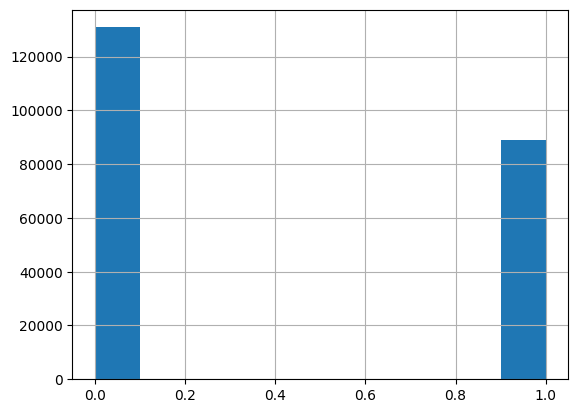

In [ ]:
# Histogram of label column.
cancer = labels.loc[labels['label']==1]['id'].values
normal = labels.loc[labels['label']==0]['id'].values
labels['label'].hist()
print(cancer)

In [ ]:
def plot_fig(ids,title,nrows=3,ncols=3):

    fig,ax = plt.subplots(nrows,ncols,figsize=(7,7))
    plt.subplots_adjust(wspace=0, hspace=0)
    for i,j in enumerate(ids[:nrows*ncols]):
        fname = os.path.join(train ,j +'.tif')
        img = Image.open(fname)
        idcol = ImageDraw.Draw(img)
        idcol.rectangle(((0,0),(95,95)),outline='white')
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(np.array(img))
        plt.axis('off')

    plt.suptitle(title, y=0.94)

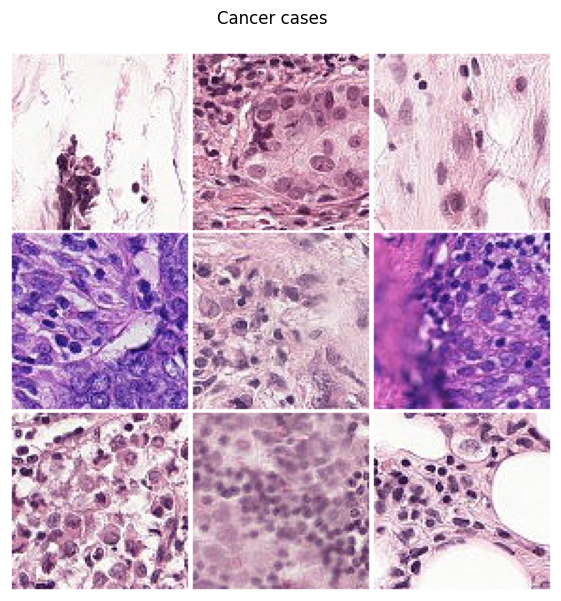

In [ ]:
# Plot some Cancer cases

plot_fig(cancer,'Cancer cases')


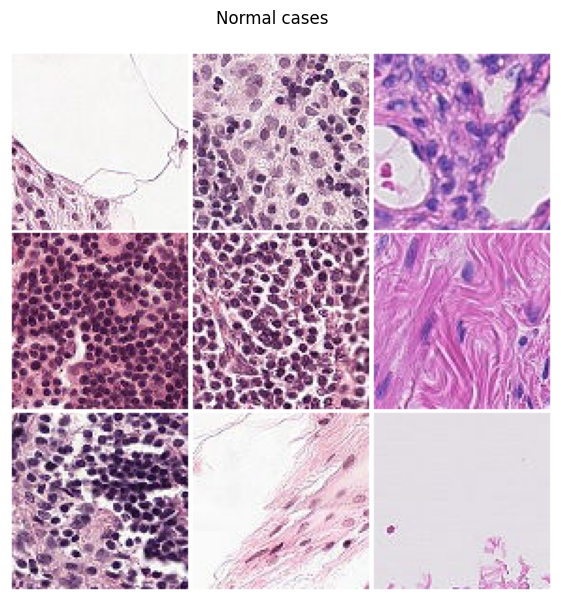

In [ ]:
# Plot some normal cases

plot_fig(normal,'Normal cases')

In [ ]:
# Split labels data to train data and validation data
train_data, val_data = train_test_split(labels, test_size = 0.2, random_state = 42, stratify=labels['label'])
train_data = train_data.astype(str)
val_data = val_data.astype(str)
print(train_data.shape, val_data.shape)

(176020, 2) (44005, 2)


In [ ]:
# Randomly gennerate some noises for data to prevent overfitting

train_data_gen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2,horizontal_flip=True)

In [ ]:
val_data_gen = ImageDataGenerator(rescale = 1./255)
test_data_gen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_data['id'] += '.tif'
val_data['id'] += '.tif'

In [ ]:

train_generator = train_data_gen.flow_from_dataframe(dataframe=train_data,directory=train, x_col ='id', y_col ='label', target_size=(96,96), batch_size =32, class_mode ='binary')

Found 176020 validated image filenames belonging to 2 classes.


In [ ]:
val_generator = val_data_gen.flow_from_dataframe(dataframe = val_data, directory = train, x_col = 'id', y_col='label', target_size=(96,96), batch_size = 32, class_mode ='binary')

Found 44005 validated image filenames belonging to 2 classes.


In [ ]:
test_data = samples.astype(str)
test_data['id'] += '.tif'

In [ ]:
test_generator = test_data_gen.flow_from_dataframe(dataframe = test_data, directory = test, x_col='id', y_col='label', target_size=(96,96), batch_size=32)

Found 57458 validated image filenames belonging to 1 classes.


## 3. Model Architecture

### First model: 4 convolutional layers

In [ ]:
def CNN_4layers(model):
    model.add(layers.Conv2D(16, (3,3), activation='relu',input_shape=(96,96,3)))
    model.add(layers.Conv2D(16, (3,3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(3,3)))

    model.add(layers.Conv2D(32, (3,3), activation='relu'))
    model.add(layers.Conv2D(32, (3,3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(3,3)))

    model.add(layers.Flatten())

    # Classification layers
    model.add(layers.Dense(64, activation='sigmoid'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [ ]:
from tensorflow.keras import Sequential
model = Sequential()
RMS_model = CNN_4layers(model)
RMS_model.compile(optimizer='RMSprop', loss = 'binary_crossentropy',metrics=[AUC(curve ="PR")])
RMS_history = RMS_model.fit(train_generator, validation_data = val_generator, epochs = 6, validation_steps=int(len(val_data)/32))

Epoch 1/6
5501/5501 [==============================] - 981s 176ms/step - loss: 0.4080 - auc: 0.8503 - val_loss: 0.3369 - val_auc: 0.9042
Epoch 2/6
5501/5501 [==============================] - 907s 165ms/step - loss: 0.3632 - auc: 0.8795 - val_loss: 0.4314 - val_auc: 0.8995
Epoch 3/6
5501/5501 [==============================] - 875s 159ms/step - loss: 0.3379 - auc: 0.8986 - val_loss: 0.5739 - val_auc: 0.7890
Epoch 4/6
5501/5501 [==============================] - 860s 156ms/step - loss: 0.3240 - auc: 0.9062 - val_loss: 0.2988 - val_auc: 0.9295
Epoch 5/6
5501/5501 [==============================] - 894s 162ms/step - loss: 0.3156 - auc: 0.9109 - val_loss: 0.3476 - val_auc: 0.9072
Epoch 6/6
5501/5501 [==============================] - 870s 158ms/step - loss: 0.3113 - auc: 0.9140 - val_loss: 0.4964 - val_auc: 0.8853


In [ ]:
RMS_history

In [ ]:
prediction_label_1 = RMS_model.predict(test_generator)

1796/1796 [==============================] - 116s 64ms/step


In [ ]:
prediction_label_1

array([[0.28261268],
       [0.15500851],
       [0.04364507],
       ...,
       [0.96351045],
       [0.9655506 ],
       [0.06504299]], dtype=float32)

In [ ]:
prediction=np.round(prediction_label_1).astype('int')
prediction_df = pd.DataFrame({'label': prediction.reshape(-1), 'id': test_data['id']})
prediction_df['id'] = prediction_df['id'].apply(lambda x: x[:-4])

In [ ]:
prediction_df

,label,id
0,0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5
1,0,95596b92e5066c5c52466c90b69ff089b39f2737
2,0,248e6738860e2ebcf6258cdc1f32f299e0c76914
3,0,2c35657e312966e9294eac6841726ff3a748febf
4,0,145782eb7caa1c516acbe2eda34d9a3f31c41fd6
...,...,...
57453,1,061847314ded6f81e1cd670748bfa2003442c9c7
57454,1,6f3977130212641fd5808210015a609c658dcbff
57455,1,46935f247278539eca74b54d07d666efb528a753
57456,1,a09bcae08a82120183352e0e869181b2911d3dc1


In [ ]:
prediction_df.to_csv('submission.csv', index=False)

### Second Model : 6 convolutional layers

In [ ]:
def CNN_6layers(model):
    model.add(layers.Conv2D(16, (3,3), activation='relu',input_shape=(96,96,3)))
    model.add(layers.Conv2D(16, (3,3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(3,3)))

    model.add(layers.Conv2D(32, (3,3), activation='relu'))
    model.add(layers.Conv2D(32, (3,3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(3,3)))

    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(3,3)))

    model.add(layers.Flatten())

    # Classification layers
    model.add(layers.Dense(64, activation='sigmoid'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [ ]:
from tensorflow.keras import Sequential
model = Sequential()
RMS_model = CNN_6layers(model)
RMS_model.compile(optimizer='RMSprop', loss = 'binary_crossentropy',metrics=[AUC(curve ="PR")])
RMS_history = RMS_model.fit(train_generator, validation_data = val_generator, epochs = 6, validation_steps=int(len(val_data)/32))

Epoch 1/6
5501/5501 [==============================] - 937s 170ms/step - loss: 0.4077 - auc_1: 0.8537 - val_loss: 0.8114 - val_auc_1: 0.7590
Epoch 2/6
5501/5501 [==============================] - 922s 168ms/step - loss: 0.3552 - auc_1: 0.8926 - val_loss: 0.4114 - val_auc_1: 0.8952
Epoch 3/6
5501/5501 [==============================] - 865s 157ms/step - loss: 0.3333 - auc_1: 0.9062 - val_loss: 0.4224 - val_auc_1: 0.9180
Epoch 4/6
5501/5501 [==============================] - 894s 162ms/step - loss: 0.3146 - auc_1: 0.9171 - val_loss: 0.7964 - val_auc_1: 0.8552
Epoch 5/6
5501/5501 [==============================] - 881s 160ms/step - loss: 0.3012 - auc_1: 0.9248 - val_loss: 0.4368 - val_auc_1: 0.8646
Epoch 6/6
5501/5501 [==============================] - 906s 165ms/step - loss: 0.2948 - auc_1: 0.9280 - val_loss: 0.5611 - val_auc_1: 0.8659


In [ ]:
prediction_label_2 = RMS_model.predict(test_generator)

1796/1796 [==============================] - 114s 64ms/step


In [ ]:
prediction2=np.round(prediction_label_2).astype('int')
prediction_df2 = pd.DataFrame({'label': prediction2.reshape(-1), 'id': test_data['id']})
prediction_df2['id'] = prediction_df2['id'].apply(lambda x: x[:-4])

In [ ]:
prediction_df2

,label,id
0,0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5
1,0,95596b92e5066c5c52466c90b69ff089b39f2737
2,1,248e6738860e2ebcf6258cdc1f32f299e0c76914
3,0,2c35657e312966e9294eac6841726ff3a748febf
4,0,145782eb7caa1c516acbe2eda34d9a3f31c41fd6
...,...,...
57453,0,061847314ded6f81e1cd670748bfa2003442c9c7
57454,1,6f3977130212641fd5808210015a609c658dcbff
57455,1,46935f247278539eca74b54d07d666efb528a753
57456,0,a09bcae08a82120183352e0e869181b2911d3dc1


In [ ]:
prediction_df2.to_csv('submission1.csv',index=False)

## 4. Results and analysis

We run models with 6 layers with diffent optimizer and different learning rates.

### Model with 6 layers , optimizer = Adam, learning rate = 0.01

In [ ]:
import keras
from tensorflow.keras import Sequential

model = Sequential()
RMS_model = CNN_6layers(model)
optimizer = keras.optimizers.Adam(lr=0.01)
RMS_model.compile(optimizer=optimizer, loss = 'binary_crossentropy',metrics=[AUC(curve ="PR")])
RMS_history = RMS_model.fit(train_generator, validation_data = val_generator, epochs = 6, validation_steps=int(len(val_data)/32))

Epoch 1/6
5501/5501 [==============================] - 4673s 849ms/step - loss: 0.4092 - auc_2: 0.8533 - val_loss: 0.3631 - val_auc_2: 0.9017
Epoch 2/6
5501/5501 [==============================] - 4781s 869ms/step - loss: 0.3524 - auc_2: 0.8934 - val_loss: 0.3200 - val_auc_2: 0.9148
Epoch 3/6
5501/5501 [==============================] - 4830s 878ms/step - loss: 0.3276 - auc_2: 0.9096 - val_loss: 0.3920 - val_auc_2: 0.8912
Epoch 4/6
5501/5501 [==============================] - 4761s 865ms/step - loss: 0.3120 - auc_2: 0.9191 - val_loss: 0.3854 - val_auc_2: 0.8983
Epoch 5/6
5501/5501 [==============================] - 4817s 876ms/step - loss: 0.2967 - auc_2: 0.9268 - val_loss: 0.3509 - val_auc_2: 0.9185
Epoch 6/6
5501/5501 [==============================] - 4970s 903ms/step - loss: 0.2836 - auc_2: 0.9328 - val_loss: 0.3078 - val_auc_2: 0.9339


#### Best result = 0.9339 at epoch 6th

### Model with 6 layers , optimizer = Adam, learning rate = 0.001

In [ ]:
model = Sequential()
RMS_model = CNN_6layers(model)
optimizer = keras.optimizers.Adam(lr=0.001)
RMS_model.compile(optimizer=optimizer, loss = 'binary_crossentropy',metrics=[AUC(curve ="PR")])
RMS_history = RMS_model.fit(train_generator, validation_data = val_generator, epochs = 6, validation_steps=int(len(val_data)/32))

Epoch 1/6
5501/5501 [==============================] - 550s 99ms/step - loss: 0.4098 - auc_1: 0.8534 - val_loss: 0.4670 - val_auc_1: 0.9040
Epoch 2/6
5501/5501 [==============================] - 542s 98ms/step - loss: 0.3522 - auc_1: 0.8940 - val_loss: 0.3219 - val_auc_1: 0.9197
Epoch 3/6
5501/5501 [==============================] - 539s 98ms/step - loss: 0.3281 - auc_1: 0.9096 - val_loss: 0.3994 - val_auc_1: 0.8773
Epoch 4/6
5501/5501 [==============================] - 542s 98ms/step - loss: 0.3118 - auc_1: 0.9185 - val_loss: 0.3525 - val_auc_1: 0.9092
Epoch 5/6
5501/5501 [==============================] - 536s 97ms/step - loss: 0.2959 - auc_1: 0.9268 - val_loss: 0.5187 - val_auc_1: 0.9213
Epoch 6/6
5501/5501 [==============================] - 520s 94ms/step - loss: 0.2844 - auc_1: 0.9326 - val_loss: 0.3505 - val_auc_1: 0.9064


#### Best result = 0.9213 at epoch 5th

### Model with 6 layers , optimizer = Adam, learning rate = 0.0001

In [ ]:
model = Sequential()
RMS_model = CNN_6layers(model)
optimizer = keras.optimizers.Adam(lr=0.0001)
RMS_model.compile(optimizer=optimizer, loss = 'binary_crossentropy',metrics=[AUC(curve ="PR")])
RMS_history = RMS_model.fit(train_generator, validation_data = val_generator, epochs = 6, validation_steps=int(len(val_data)/32))

Epoch 1/6
5501/5501 [==============================] - 530s 96ms/step - loss: 0.4045 - auc_2: 0.8577 - val_loss: 0.5214 - val_auc_2: 0.8433
Epoch 2/6
5501/5501 [==============================] - 532s 97ms/step - loss: 0.3466 - auc_2: 0.8976 - val_loss: 0.5084 - val_auc_2: 0.8878
Epoch 3/6
5501/5501 [==============================] - 528s 96ms/step - loss: 0.3216 - auc_2: 0.9128 - val_loss: 0.3998 - val_auc_2: 0.8854
Epoch 4/6
5501/5501 [==============================] - 531s 96ms/step - loss: 0.3035 - auc_2: 0.9221 - val_loss: 0.3763 - val_auc_2: 0.9024
Epoch 5/6
5501/5501 [==============================] - 539s 98ms/step - loss: 0.2878 - auc_2: 0.9304 - val_loss: 0.6088 - val_auc_2: 0.8929
Epoch 6/6
5501/5501 [==============================] - 538s 98ms/step - loss: 0.2780 - auc_2: 0.9353 - val_loss: 0.2570 - val_auc_2: 0.9468


#### Best result = 0.9464 at epoch 6th

In [ ]:
prediction_label_8 = RMS_model.predict(test_generator)
prediction8=np.round(prediction_label_8).astype('int')
prediction_df8 = pd.DataFrame({'label': prediction8.reshape(-1), 'id': test_data['id']})
prediction_df8['id'] = prediction_df8['id'].apply(lambda x: x[:-4])

1796/1796 [==============================] - 46s 26ms/step


In [ ]:
prediction_df8.to_csv('submission8.csv',index=False)

In [ ]:
from google.colab import files

files.download('submission8.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Model with 6 layers , optimizer = Adam, learning rate = 0.0005

In [ ]:
model = Sequential()
RMS_model = CNN_6layers(model)
optimizer = keras.optimizers.Adam(lr=0.0005)
RMS_model.compile(optimizer=optimizer, loss = 'binary_crossentropy',metrics=[AUC(curve ="PR")])
RMS_history = RMS_model.fit(train_generator, validation_data = val_generator, epochs = 6, validation_steps=int(len(val_data)/32))

Epoch 1/6
5501/5501 [==============================] - 542s 98ms/step - loss: 0.4057 - auc_3: 0.8554 - val_loss: 0.4086 - val_auc_3: 0.8878
Epoch 2/6
5501/5501 [==============================] - 535s 97ms/step - loss: 0.3455 - auc_3: 0.8981 - val_loss: 0.3204 - val_auc_3: 0.9254
Epoch 3/6
5501/5501 [==============================] - 536s 97ms/step - loss: 0.3155 - auc_3: 0.9164 - val_loss: 0.6617 - val_auc_3: 0.8802
Epoch 4/6
5501/5501 [==============================] - 542s 98ms/step - loss: 0.2950 - auc_3: 0.9273 - val_loss: 1.0618 - val_auc_3: 0.7351
Epoch 5/6
5501/5501 [==============================] - 543s 99ms/step - loss: 0.2799 - auc_3: 0.9352 - val_loss: 0.3210 - val_auc_3: 0.9214
Epoch 6/6
5501/5501 [==============================] - 545s 99ms/step - loss: 0.2699 - auc_3: 0.9394 - val_loss: 1.1217 - val_auc_3: 0.7152


#### Best result = 0.9254 at epoch 2nd

## 5. Conclusion

We saw that the model with 6 convolutional layers, optimizer = Adam, and learning rate = 0.0001 had the best result = 0.9464 at the epoch 6th. So I decided to choose this model to predict the sample labels.

After submitted to Kaggle, we had the result = 0.5004. I think we can add more layers on the model to have the better result.

---



---

